# Seminar on Automatic Differentiation with JAX - 23/02/2023

T. Teijeiro - *tteijeiro@bcamath.org*

*From [Wikipedia](https://en.wikipedia.org/wiki/Automatic_differentiation):* "Automatic differentiation (AutoDiff or AD) is a set of techniques to numerically **evaluate the derivative of a function specified by a computer program**. Derivatives of arbitrary order can be computed automatically, accurately to working precision, and using at most a small constant factor more arithmetic operations than the original program".


## 1. AutoDiff as a Black-Box API

For most of the users and use cases, AD can be seen as a Black-Box API with a single [higher-order function](https://en.wikipedia.org/wiki/Higher-order_function): `grad`. This function receives a function `f` as a parameter, and returns another function `df` which evaluates the gradient of `f`. That's it.

In [1]:
from jax import grad

This import is enough to have AD functionality with any **scalar-valued function** we may program in Python. Higher-order derivatives are also possible without any limitation or precision loss.

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


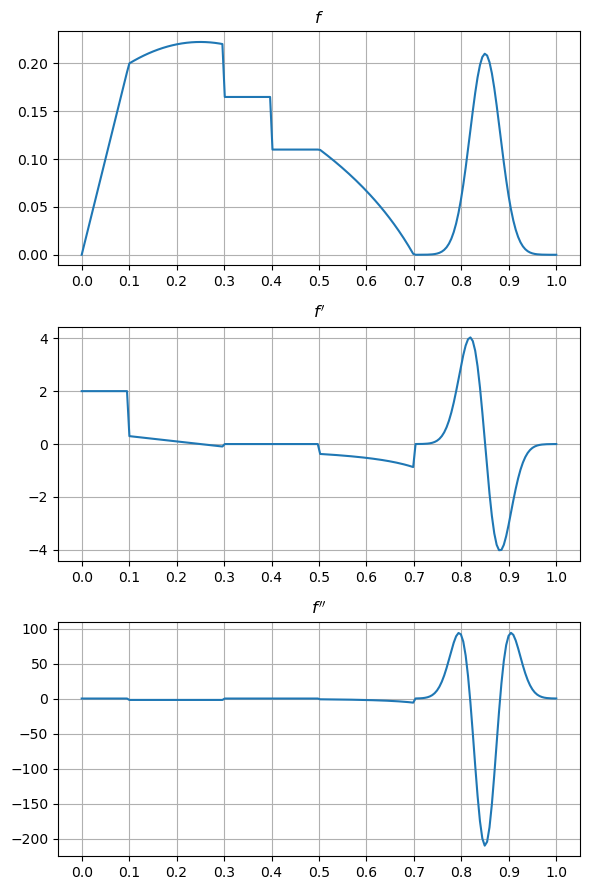

In [3]:
#Entangled function using many different programming constructs.
def f(x):
    if 0 <= x <= 1:
        if x < 0.1:
            return 2*x
        if x < 0.3:
            return 0.2225-(x-0.25)**2
        for i in range(2):
            if (x-0.3)//0.1 == i:
                return 0.165 if i==0 else f(x-0.1)-0.055
        if x < 0.7:
            x = 0.5+(x-0.5)*1.4412477
            return 0.2+jnp.log(1-x)/7.75
        return jax.scipy.stats.multivariate_normal.pdf(x, 0.85, 0.001)/60
    return 0

#AutoDiff on f. Higher-order derivatives are possible and work as expected
df = grad(f)
ddf = grad(df)

X = np.linspace(0, 1, 200)

plt.figure(figsize=(6, 9))
ax1 = plt.subplot(311)
ax1.plot(X, [f(x) for x in X])
ax1.grid()
ax1.set_title('$f$')
ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(X, [df(x) for x in X])
ax2.grid()
ax2.set_title("$f'$")
ax3 = plt.subplot(313, sharex=ax1)
ax3.plot(X, [ddf(x) for x in X])
ax3.grid()
ax3.set_title("$f''$")
plt.xticks(np.linspace(0, 1, 11))
plt.tight_layout()

## 2. The Working Principles of AD

AD is neither [numerical differentiation](https://en.wikipedia.org/wiki/Numerical_differentiation) (i.e., finite differences) nor [symbolic differentiation](https://en.wikipedia.org/wiki/Symbolic_differentiation), but has aspects of both. As a working principle, AD starts from the assumption that any differentiable function $F:\mathbb{R}^n \rightarrow \mathbb{R}^m$ can be described as the **composition of elementary functions for which the exact derivative is known**, and then applies the **[chain rule](https://en.wikipedia.org/wiki/Chain_rule)** on this composition. Let's consider the following example:

$$F = D\circ C \circ B \circ A\\ y=F(x) = D(C(B(A(x))))$$

then, if we name: $\mathbf{a}=A(x), \mathbf{b}=B(\mathbf{a}), \mathbf{c}=C(\mathbf{b}), y=D(\mathbf{c})$, we have that:

\begin{equation*}
F'(x) = \frac{\partial y}{\partial \mathbf{c}} \frac{\partial \mathbf{c}}{\partial \mathbf{b}} \frac{\partial \mathbf{b}}{\partial \mathbf{a}} \frac{\partial \mathbf{a}}{\partial x} \tag{1}
\end{equation*}

Basically everything about AD is the calculation of the above expression in a **computationally efficient** manner, and for this there are two main strategies: forward-mode and reverse-mode.

#### TLDR; Forward-mode vs. Reverse-mode Differentiation:

Considering a target function $F:\mathbb{R}^n \rightarrow \mathbb{R}^m$:
 - Reverse-mode differentiation is much more computationally efficient if $n >> m$ (requires running $F$ $m$ times, and building a call graph for backward accumulation).
 - Forward-mode differentiation is much more computationally efficient if $m >> n$, and is always much more memory-efficient (requires running $F$ $n$ times).

### 2.1 AD Flavors: Forward-Mode and Reverse-Mode
 

There are two main approaches for calculating equation (1), depending on the order followed to accumulate the gradients of each elementary function, which give name to the classical methods of AD: forward-mode and reverse-mode. Conceptually, the difference is as simple as:

 - Forward mode: $F'(x) = \frac{\partial y}{\partial \mathbf{c}} \left( \frac{\partial \mathbf{c}}{\partial \mathbf{b}} \left( \frac{\partial \mathbf{b}}{\partial \mathbf{a}} \frac{\partial \mathbf{a}}{\partial x} \right) \right)$. Derivatives are calculated following the same order as function evaluation, from inputs to outputs.
 
 
 - Reverse mode: $F'(x) = \left( \left(\frac{\partial y}{\partial \mathbf{c}} \frac{\partial \mathbf{c}}{\partial \mathbf{b}} \right) \frac{\partial \mathbf{b}}{\partial \mathbf{a}} \right) \frac{\partial \mathbf{a}}{\partial x}$. Derivatives are calculated in the inverse order as function evaluation, from outputs to inputs.

This innocent-looking difference has huge implications in terms of computational complexity and memory consumption. The animations below show the step-by-step calculations that are required to implement these two modes for the function $f(x_1, x_2) = x_1*x_2 + sin(x_1)$. The animations are shown over a *call graph* which determines the order of evaluation of the elementary functions that compose our target function $f$:

In [4]:
from IPython.display import IFrame
IFrame(src="https://docs.google.com/presentation/d/e/2PACX-1vS5GANK-J-iXK2jwlc4XgJbD3o67Isq90hGAC0Pgb_wFP_VAc3Evgpmu45fBRTh8wA46qAQ8pywWHEM/embed?start=false&loop=false", width="800", height="475")

In forward-mode differentiation, the derivative values $w$ can be calculated along with the execution of the function, in the same normal evaluation. This leads to an extremely memory-efficient implementation, with basically no overhead. However, we need to run the function **as many times as the number of input variables we have**. In practice, forward-mode is equivalent to finite differences in terms of complexity (memory and time).

On the other hand, in reverse-mode differentiation, we can calculate the derivatives with respect to all input variables **in a single forward-backward pass**. For this, *adjoint variables* $ŵ$ are used, which start from the output and define which calculations are required at each edge to estimate the derivative of the output with respect to the inputs. Once we have calculated the output of the function, we can solve all the adjoint expressions by going backwards in the call graph and obtain the derivatives with respect to all inputs at once. However, if we have **multiple outputs, we need to solve the adjoint expressions once for each output**. The main drawback of reverse-mode with respect to forward-mode is that the call graph needs to be stored in memory.

## 3. How AD is Actually Implemented (in JAX)

As an abstraction principle, JAX's AD subsystem is based on the notion of [Jacobian Matrices](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant), their composition and decomposition. As illustrated in the image below, the chain rule is then seen as the multiplication of the jacobian matrices for each of the elementary functions, and the forward and reverse modes correspond to the order of matrix multiplication (forward=right-to-left, reverse=left-to-right):


<img src="figs/jacobians_mult.svg" width="500"/>

This picture shows clearly which are the use cases more favorable to forward and reverse modes: In case $F$ is a scalar function, reverse mode is reduced to vector-matrix multiplications.

JAX provides two convenient functions, `jacfwd` and `jacrev`, to compute full Jacobian matrices using forward or reverse mode. This is probably the easiest way to get started with AD on vector-valued functions:

In [5]:
from jax import jacfwd, jacrev

#We differentiate the matrix-inverse function
dinv_fwd = jacfwd(jnp.linalg.inv)
dinv_rev = jacrev(jnp.linalg.inv)

m = np.random.rand(4, 4)
jm_fwd = dinv_fwd(m)
jm_rev = dinv_rev(m)
#We check that both functions calculate the same value
print(f'Same results in fwd/rev: {jnp.allclose(jm_fwd, jm_rev)}')
print(f'Shape of the Jacobian: {jm_fwd.shape}')
m = np.random.rand(40, 40)
%timeit dinv_fwd(m)
%timeit dinv_rev(m)

Same results in fwd/rev: True
Shape of the Jacobian: (4, 4, 4, 4)
24.9 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
23.8 ms ± 832 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


However, calculating full Jacobian matrices is usually unfeasible:

In [6]:
m = np.random.rand(400, 400)
jm_fwd = dinv_fwd(m) #Throws memory exception

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory allocating 102400000000 bytes.

That is why, in practice, the full Jacobian matrices are never instantiated, and calculations focus on Vector-Jacobian (forward mode) and Jacobian-Vector (reverse mode) products, named VJP and JVP. **These are the foundational functions for JAX's AD system**.

The JAX AD method **consists of three basic steps**:
 1. Tracing the composition of primitive functions at runtime.
 2. Defining a JVP/VJP operator for each primitive.
 3. Composing JVPs/VJPs in forward or reverse mode.

### 3.1 Execution Tracing

The first step consists of analyzing the execution of the function to be differentiated to identify the primitive functions to be composed and build the call graph. Each one of these primitive functions is then wrapped with a JAX-function with the same interface, but which is responsible for boxing and unboxing the arguments for the original function together with the metadata required for the tracing. An example is shown in the image below:

<img src="figs/tracing.svg" width=70%/>

The result of this tracing is a directed acyclic graph (DAG) with all elementary functions as nodes, and **without any flow control** (this is different for example than what TensorFlow does). This DAG is created dynamically at runtime and for each individual execution of the function.

<img src="figs/graph.svg" width=70%/>


### 3.2 Defining a JVP/VJP operator for each primitive

This step is conceptually the closest one to symbolic differentiation. Consists of defining a JVP/VJP operator for each of the primitive functions to be composed. This operator has to calculate the derivative of the primitive function, and it will be used to compose the full derivative of the call graph. For example, VJP enable reverse-mode differentiation as follows:

<img src="figs/vjp.svg" width=40%/>


In general, these VJP have to be manually programmed. By default, JAX includes VJPs for all `numpy`, part of `scipy`, and all native python operations (addition, multiplication, exponentiation, etc.). Some examples of how thes VJPs are defined are shown below:

<img src="figs/defvjp.svg" width=70%/>

While VJPs **[only work for reverse-mode differentiation](https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html#use-jax-custom-vjp-to-define-custom-reverse-mode-only-rules)**, it is also possible to define JVPs that can be used both in forward and reverse modes. If we want to define new primitive functions (e.g. because they are programmed in non-python languages), all we need to do to make them working with JAX's AD subsystem is to define the corresponding JVP/VJP. However, this may not be trivial at all, and it is usually a better approach to build every function to be differentiated by means of JAX primitives. An interesting [tutorial on how to write custom JVP/VJP code](https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html) is available in the JAX documentation.

#### Usage Warning: *Approximate the Derivative, don't Differentiate the Approximation*

Automatic Differentiation as a concept has one main assumption that can lead to serious inaccuracies if not properly used, and that is that it **does not commute with approximation**. That is, AD will give you derivatives of the procedure you actually programmed, which may not be good approximations of the derivatives of the ideal function that your procedure was approximating.

Let's show a basic example with a function approximating $e^x$ using a sum of of *n* terms of the Taylor Series:

In [7]:
def exponential(x, n=10):
    """
    Approximates exp(x) using a truncated sum of n elements of the Taylor Series.
    """
    s = 1.0
    for i in range(n, 0, -1):
        s = 1 + x * s / i
    return s
 
#Approximation of e with 10 elements
e = exponential(1.0)
print (f"Error in the approximation of the function: {jnp.exp(1)-e}")

Error in the approximation of the function: 0.0


Now we calculate the derivative (and higher-order derivatives) of this function using JAX, and we estimate the error in the approximation:

In [8]:
print(f"Error in the approximation of the derivative: {jax.grad(exponential)(1.)-e}")
print(f"Error in the approximation of the 2nd derivative: {jax.grad(jax.grad(exponential))(1.0)-e}")
print(f"Error in the approximation of the 3nd derivative: {jax.grad(jax.grad(jax.grad(exponential)))(1.0)-e}")

Error in the approximation of the derivative: -2.384185791015625e-07
Error in the approximation of the 2nd derivative: -2.86102294921875e-06
Error in the approximation of the 3nd derivative: -2.7894973754882812e-05


As we can see for this sexample, the error in approximating the derivative increases by **one order of magnitude with each differentiation**.

### 3.3 Composing JVPs/VJPs in forward or reverse mode

*This section has been mostly taken from: https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html*

#### Mathematical definition of JVPs

Mathematically, given a function $f : \mathbb{R}^n \to \mathbb{R}^m$, the Jacobian of $f$ evaluated at an input point $x \in \mathbb{R}^n$, denoted $\partial f(x)$, is often thought of as a matrix in $\mathbb{R}^m \times \mathbb{R}^n$:

$\qquad \partial f(x) \in \mathbb{R}^{m \times n}$.

But we can also think of $\partial f(x)$ as a linear map, which maps the tangent space of the domain of $f$ at the point $x$ (which is just another copy of $\mathbb{R}^n$) to the tangent space of the codomain of $f$ at the point $f(x)$ (a copy of $\mathbb{R}^m$):

$\qquad \partial f(x) : \mathbb{R}^n \to \mathbb{R}^m$.

This map is called the [pushforward map](https://en.wikipedia.org/wiki/Pushforward_(differential)) of $f$ at $x$. The Jacobian matrix is just the matrix for this linear map in a standard basis.

If we don't commit to one specific input point $x$, then we can think of the function $\partial f$ as first taking an input point and returning the Jacobian linear map at that input point:

$\qquad \partial f : \mathbb{R}^n \to \mathbb{R}^n \to \mathbb{R}^m$.

In particular, we can uncurry things so that given input point $x \in \mathbb{R}^n$ and a tangent vector $v \in \mathbb{R}^n$, we get back an output tangent vector in $\mathbb{R}^m$. We call that mapping, from $(x, v)$ pairs to output tangent vectors, the *Jacobian-vector product*, and write it as

$\qquad (x, v) \mapsto \partial f(x) v$

In Python code, JAX's `jvp` function models this transformation. Given a Python function that evaluates $f$, JAX's `jvp` is a way to get a Python function for evaluating $(x, v) \mapsto (f(x), \partial f(x) v)$. This corresponds to the *directional derivative of $f$ at $x$ in the direction of $v$*. To build the full Jacobian matrix, we can use `jvp` to get one column at a time, thus requiring *n* calls to the function.

#### Mathematical definition of VJPs

Where forward-mode gives us back a function for evaluating Jacobian-vector products, which we can then use to build Jacobian matrices one column at a time, reverse-mode is a way to get back a function for evaluating vector-Jacobian products (equivalently Jacobian-transpose-vector products), which we can use to build Jacobian matrices one row at a time.

Let's again consider a function $f : \mathbb{R}^n \to \mathbb{R}^m$.
Starting from our notation for JVPs, the notation for VJPs is pretty simple:

$\qquad (x, v) \mapsto v \partial f(x)$,

where $v$ is an element of the cotangent space of $f$ at $x$ (isomorphic to another copy of $\mathbb{R}^m$). With that identification, we can alternatively think of the linear part of a VJP as the transpose (or adjoint conjugate) of the linear part of a JVP:

$\qquad (x, v) \mapsto \partial f(x)^\mathsf{T} v$.

For a given point $x$, we can write the signature as

$\qquad \partial f(x)^\mathsf{T} : \mathbb{R}^m \to \mathbb{R}^n$.

The corresponding map on cotangent spaces is often called the [pullback](https://en.wikipedia.org/wiki/Pullback_(differential_geometry))
of $f$ at $x$. The key for our purposes is that it goes from something that looks like the output of $f$ to something that looks like the input of $f$, just like we might expect from a transposed linear function.

Switching from math back to Python, the JAX function `vjp` can take a Python function for evaluating $f$ and give us back a Python function for evaluating the VJP $(x, v) \mapsto (f(x), v^\mathsf{T} \partial f(x))$.

Let us illustrate the use of `jvp` and `vjp` with a simple example of a function $f: \mathbb{R}^3 \mapsto \mathbb{R}^2$. $f_2(x, y, z) = \langle 3x+y+z^2, x-z\rangle$

In [9]:
#The function is defined on arrays for easing the visualization.
def f2(x):
    return jnp.array([3*x[0]+x[1]+x[2]**2, x[0]-x[2]])

x0 = np.array([1., 1., 1.])
#First we visualize the Jacobian at (1, 1, 1)
print('Jacobian matrix:')
print(jax.jacfwd(f2)(x0))

#We obtain the Jacobian through jvp (one column at a time)
print('Columns obtained through jvp:')
print(jax.jvp(f2, (x0,), (np.array([1., 0., 0.]),))[1])
print(jax.jvp(f2, (x0,), (np.array([0., 1., 0.]),))[1])
print(jax.jvp(f2, (x0,), (np.array([0., 0., 1.]),))[1])

#And through vjp (one row at a time)
print('Rows obtained through vjp:')
vf2, vjp_x0 = jax.vjp(f2, x0)
print(vjp_x0(np.array([1., 0.]))[0])
print(vjp_x0(np.array([0., 1.]))[0])

Jacobian matrix:
[[ 3.  1.  2.]
 [ 1.  0. -1.]]
Columns obtained through jvp:
[3. 1.]
[1. 0.]
[ 2. -1.]
Rows obtained through vjp:
[3. 1. 2.]
[ 1.  0. -1.]


## References:
 1. General Introduction to Automatic Differentiation (language-independent): https://alexey.radul.name/ideas/2013/introduction-to-automatic-differentiation
 2. The JAX Autodiff Cookbook: https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html
 3. Lecture about Autograd by Matthew J. Johnson (one of JAX's creators): http://videolectures.net/deeplearning2017_johnson_automatic_differentiation/
 4. Wikipedia entry on Automatic Differentiation: https://en.wikipedia.org/wiki/Automatic_differentiation
 5. How to write custom derivative rules for JAX: https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html